# A1.6 · Regresión no lineal — Tiempo de Entrega vs Calificación
## Camila Johana González Acosta 599303

En este ejercicio analizaremos si existe relación entre el tiempo de entrega de una tarea y la calificación obtenida. Se probarán tres métodos de egresión no lineal: Regresión polinomial, regresión segmentada y KNN para regresión. 


## 1.Cargar librerias y datos

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

df = pd.read_csv("A1.6 Tiempo de Entrega.csv")
x = df["Tiempo"].values
y = df["Calificacion"].values

# Aseguramos que sean floats
x = pd.to_numeric(df.iloc[:, 0], errors="coerce").values
y = pd.to_numeric(df.iloc[:, 1], errors="coerce").values

# Quitamos filas con NaN
mask = ~np.isnan(x) & ~np.isnan(y)
x = x[mask]
y = y[mask]

# Filtrar datos, se toman en cuenta horas de 0 a 100
mask = (x >= 0) & (x <= 100)
x = x[mask]
y = y[mask]

print("Observaciones después de filtrar:", len(x))

Observaciones después de filtrar: 416


## 2.Grafica de dispersión inicial

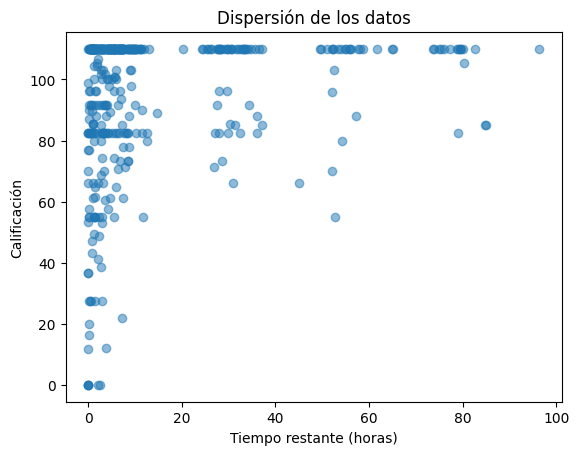

In [5]:
plt.scatter(x, y, alpha=0.5)
plt.xlabel("Tiempo restante (horas)")
plt.ylabel("Calificación")
plt.title("Dispersión de los datos")
plt.show()

## 3 Separar en train/test (70/30)

In [6]:
X = x.reshape(-1, 1)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42
)

print("Promedio Tiempo (train/test):", X_train.mean(), X_test.mean())
print("Promedio Calificación (train/test):", y_train.mean(), y_test.mean())
# Comentario: comparar si train y test son representativos.

Promedio Tiempo (train/test): 12.969173348642611 15.75292666672
Promedio Calificación (train/test): 94.02574704467354 96.32759464


Los datos de entrenamiento y prueba son representativos, aunque el conjunto de prueba muestra entregas en promedio un poco más tempranas (15.7 h vs. 13 h) y calificaciones ligeramente más altas (96.3 vs. 94), lo que podría favorecer un desempeño algo mejor en ese subconjunto.

## 4.Regresión Polinomial (grado 2)

In [7]:
coef_poly = np.polyfit(X_train.flatten(), y_train, 2)
poly = np.poly1d(coef_poly)

print("\nCoeficientes polinomio grado 2:", coef_poly)
print("Interpretación: el término lineal (coef. x) es", coef_poly[1])

y_pred_poly = poly(X_test.flatten())


Coeficientes polinomio grado 2: [-6.35204697e-03  6.86177988e-01  8.85966092e+01]
Interpretación: el término lineal (coef. x) es 0.6861779875957131


El coeficiente lineal positivo (aprox. 0.69) indica que, en promedio, a mayor tiempo restante al entregar, mayor es la calificación obtenida, apoyando la hipótesis de que entregar con anticipación se asocia con mejores resultados.

## 5.Regresión Segmentada 
2 tramos con corte en la mediana de train

In [8]:
corte = np.median(X_train)
mask1 = X_train.flatten() <= corte
mask2 = X_train.flatten() > corte

coef_seg1 = np.polyfit(X_train.flatten()[mask1], y_train[mask1], 2)
coef_seg2 = np.polyfit(X_train.flatten()[mask2], y_train[mask2], 2)

poly_seg1 = np.poly1d(coef_seg1)
poly_seg2 = np.poly1d(coef_seg2)

# Predicciones en test
y_pred_seg = []
for xi in X_test.flatten():
    if xi <= corte:
        y_pred_seg.append(poly_seg1(xi))
    else:
        y_pred_seg.append(poly_seg2(xi))
y_pred_seg = np.array(y_pred_seg)

## 6.KNN para regresión (con estandarización)

In [9]:
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std  = scaler.transform(X_test)

def knn_predict(x_train, y_train, x_new, k=5):
    preds = []
    for xi in x_new:
        dist = np.abs(x_train.flatten() - xi)
        idx = np.argsort(dist)[:k]
        preds.append(np.mean(y_train[idx]))
    return np.array(preds)

y_pred_knn = knn_predict(X_train_std, y_train, X_test_std.flatten(), k=5)

## 7.Cálculo del RSE

In [10]:
def RSE(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred)**2))

rse_poly = RSE(y_test, y_pred_poly)
rse_seg  = RSE(y_test, y_pred_seg)
rse_knn  = RSE(y_test, y_pred_knn)

print("\nRSE Polinomio:", rse_poly)
print("RSE Segmentada:", rse_seg)
print("RSE KNN:", rse_knn)


RSE Polinomio: 23.536641145870387
RSE Segmentada: 22.10356047106696
RSE KNN: 23.03220859949766


## Grafica comparativa

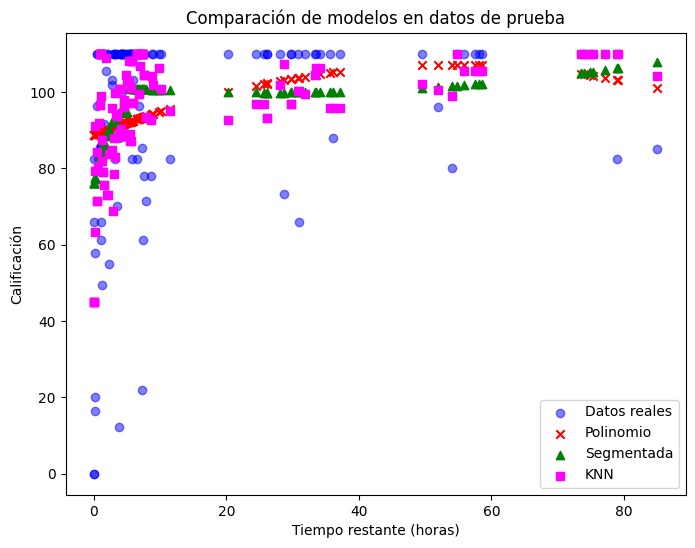

In [11]:
plt.figure(figsize=(8,6))
plt.scatter(X_test, y_test, alpha=0.5, label="Datos reales", color="blue")
plt.scatter(X_test, y_pred_poly, color="red", marker="x", label="Polinomio")
plt.scatter(X_test, y_pred_seg, color="green", marker="^", label="Segmentada")
plt.scatter(X_test, y_pred_knn, color="magenta", marker="s", label="KNN")

plt.xlabel("Tiempo restante (horas)")
plt.ylabel("Calificación")
plt.title("Comparación de modelos en datos de prueba")
plt.legend()
plt.show()

La gráfica muestra que los tres modelos (polinomial, segmentado y KNN) logran aproximar el patrón general de las calificaciones, aunque con matices: el polinomial y el segmentado siguen una tendencia más suave y consistente, mientras que el KNN reproduce con mayor detalle la dispersión de los datos; en conjunto, los resultados sugieren que las calificaciones se mantienen altas sin importar mucho el tiempo restante, con solo una ligera ventaja al entregar con más anticipación.
